<a href="https://colab.research.google.com/github/simulate111/Data-Science_2024/blob/main/Mini%20Project%201%20%E2%80%93%20What%20should%20I%20cook%20tonight.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
from bs4 import BeautifulSoup
import logging

logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')

def scrape_recipe_details(link):
    headers = {'User-Agent': 'Mozilla/5.0'}
    try:
        response = requests.get(link, headers=headers, timeout=10)
        response.raise_for_status()  # Raise an error for bad responses
    except requests.RequestException as e:
        logging.error(f"Failed to retrieve recipe: {link} - {e}")
        return {}

    soup = BeautifulSoup(response.text, 'html.parser')

    try:
        title = soup.select_one('.entry-title')
        image = soup.select_one('.wp-block-image img')
        ww_points = soup.select_one('.recipe-meta-value.recipe-ww-pp')

        # Extracting titles from the links in the new class structure
        recipe_titles = soup.select('ul.cat-icons.post-icons a')
        recipe_keys_list = [key['title'] for key in recipe_titles if 'title' in key.attrs]

        calories_container = soup.select_one('.wprm-nutrition-label-text-nutrition-container-calories')
        calories_value = (calories_container.select_one('.wprm-nutrition-label-text-nutrition-value').get_text(strip=True)
                          if calories_container else "N/A")

        # Only return data if calories are not "N/A"
        if calories_value == "N/A":
            logging.info(f"Skipping recipe due to N/A calories: {link}")
            return {}

        title = title.get_text(strip=True) if title else "N/A"
        image_src = image['src'] if image else "N/A"
        points_value = ww_points.get_text(strip=True) if ww_points else "N/A"  # Renamed variable

        logging.debug(f"Title: {title}")
        logging.debug(f"Image: {image_src}")
        logging.debug(f"Points: {points_value}")  # Updated log message
        logging.debug(f"Recipe Keys: {recipe_keys_list}")  # Updated log message
        logging.debug(f"Calories: {calories_value}")

        return {
            'Name of the Food': title,
            'Image of the Food': image_src,
            'Calories': calories_value,
            'Points': points_value,
            'The recipe Key': recipe_keys_list  # Changed back to "The recipe Key"
        }
    except Exception as e:
        logging.error(f"Error extracting data from {link}: {e}")
        return {}


In [101]:
pip install tqdm


In [121]:
import sys
import os
from tqdm import tqdm  # Import tqdm for the progress bar

# Function to suppress output
class SuppressOutput:
    def __enter__(self):
        self._original_stdout = sys.stdout  # Save a reference to the original standard output
        sys.stdout = open(os.devnull, 'w')  # Redirect standard output to os.devnull

    def __exit__(self, exc_type, exc_value, traceback):
        sys.stdout.close()  # Close the file
        sys.stdout = self._original_stdout  # Restore original standard output

# Scrape the first 5 pages
all_recipes = []
with SuppressOutput():  # Use the context manager to suppress output
    for page in tqdm(range(1, 3), bar_format='{bar}| {n_fmt}/{total_fmt} pages', leave=False):
        recipes = scrape_skinnytaste(page)
        all_recipes.extend(recipes)


In [122]:
# Check the contents of all_recipes
print(f"Total recipes collected: {len(all_recipes)}")  # Debugging line

# Create a DataFrame and display the results
df = pd.DataFrame(all_recipes)
display(df)

Total recipes collected: 34


,Name of the Food,Image of the Food,Calories,Points,The recipe Key
0,Apple Butter,https://www.skinnytaste.com/wp-content/uploads...,34,1,"[Dairy Free Recipes, Gluten Free, Kid Friendly..."
1,Roasted Delicata Squash,https://www.skinnytaste.com/wp-content/uploads...,177,4,"[Dairy Free Recipes, Gluten Free, Vegetarian M..."
2,Apple Bread,https://www.skinnytaste.com/wp-content/uploads...,124,4,[Vegetarian Meals]
3,Autumn Salad with Pears and Gorgonzola,https://www.skinnytaste.com/wp-content/uploads...,175,5,"[Gluten Free, Low Carb, Under 30 Minutes, Vege..."
4,Sesame Chicken,https://www.skinnytaste.com/wp-content/uploads...,513,9,"[Dairy Free Recipes, Freezer Meals, Gluten Fre..."
5,Bacon in the Oven,https://www.skinnytaste.com/wp-content/uploads...,60,2,"[Dairy Free Recipes, Gluten Free, High Protein..."
6,Pumpkin Spice Latte,https://www.skinnytaste.com/wp-content/uploads...,115,7,"[Dairy Free Recipes, Gluten Free, Vegetarian M..."
7,Homemade Hamburger Helper,https://www.skinnytaste.com/wp-content/uploads...,453,12,"[Dairy Free Recipes, Gluten Free, High Protein..."
8,Fried Brown Rice,https://www.skinnytaste.com/wp-content/uploads...,276,6,"[Dairy Free Recipes, Gluten Free, High-Fiber R..."
9,Asian Grilled Chicken,https://www.skinnytaste.com/wp-content/uploads...,288.5,4,"[Dairy Free Recipes, Gluten Free, Kid Friendly..."


In [107]:
pip install pandas matplotlib seaborn


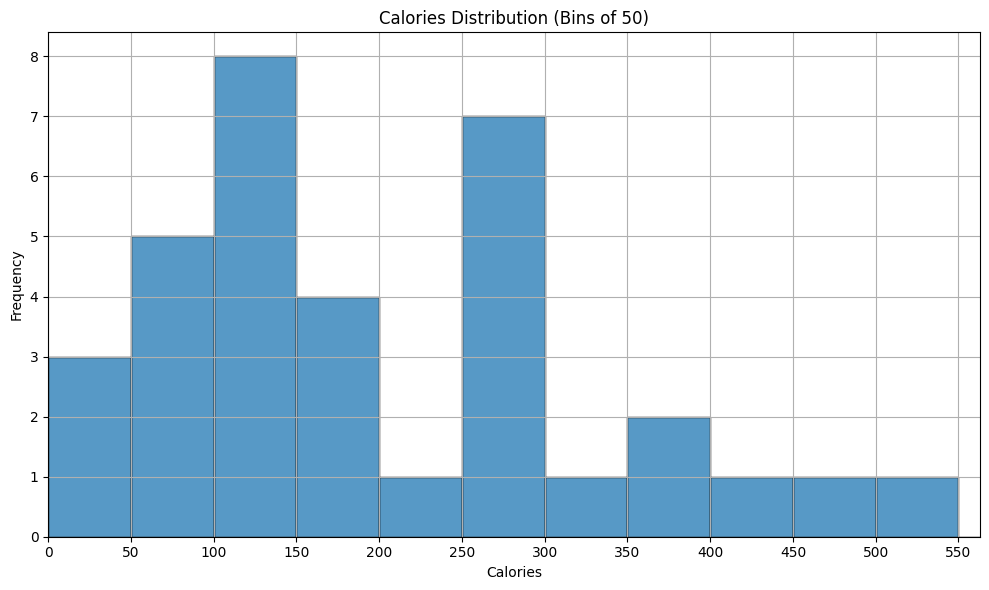

In [141]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure 'Calories' column is numeric
df['Calories'] = pd.to_numeric(df['Calories'], errors='coerce')

# Define the maximum limit for the data
max_limit = df['Calories'].max() + 50 if not df['Calories'].isnull().all() else 300  # Adjust if needed
bin_size = 50

# Calculate bins dynamically
bins = range(0, int(max_limit) + bin_size, bin_size)  # Create bins based on max limit

# Plotting Calories Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['Calories'], bins=bins, kde=False)  # Set kde=False to show just the histogram
plt.title('Calories Distribution (Bins of 50)')
plt.xlabel('Calories')
plt.ylabel('Frequency')

# Set x-ticks to show the bin values as labels
plt.xticks(bins)  # Show the bin values as labels (0, 50, 100, etc.)
plt.xlim(0, int(max_limit))  # Adjust the x-axis limits to match your bin range

plt.grid()
plt.tight_layout()  # Ensure everything fits well
plt.show()


<ipython-input-144-eaf9fcf42d77>:12: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()  # Ensure everything fits well


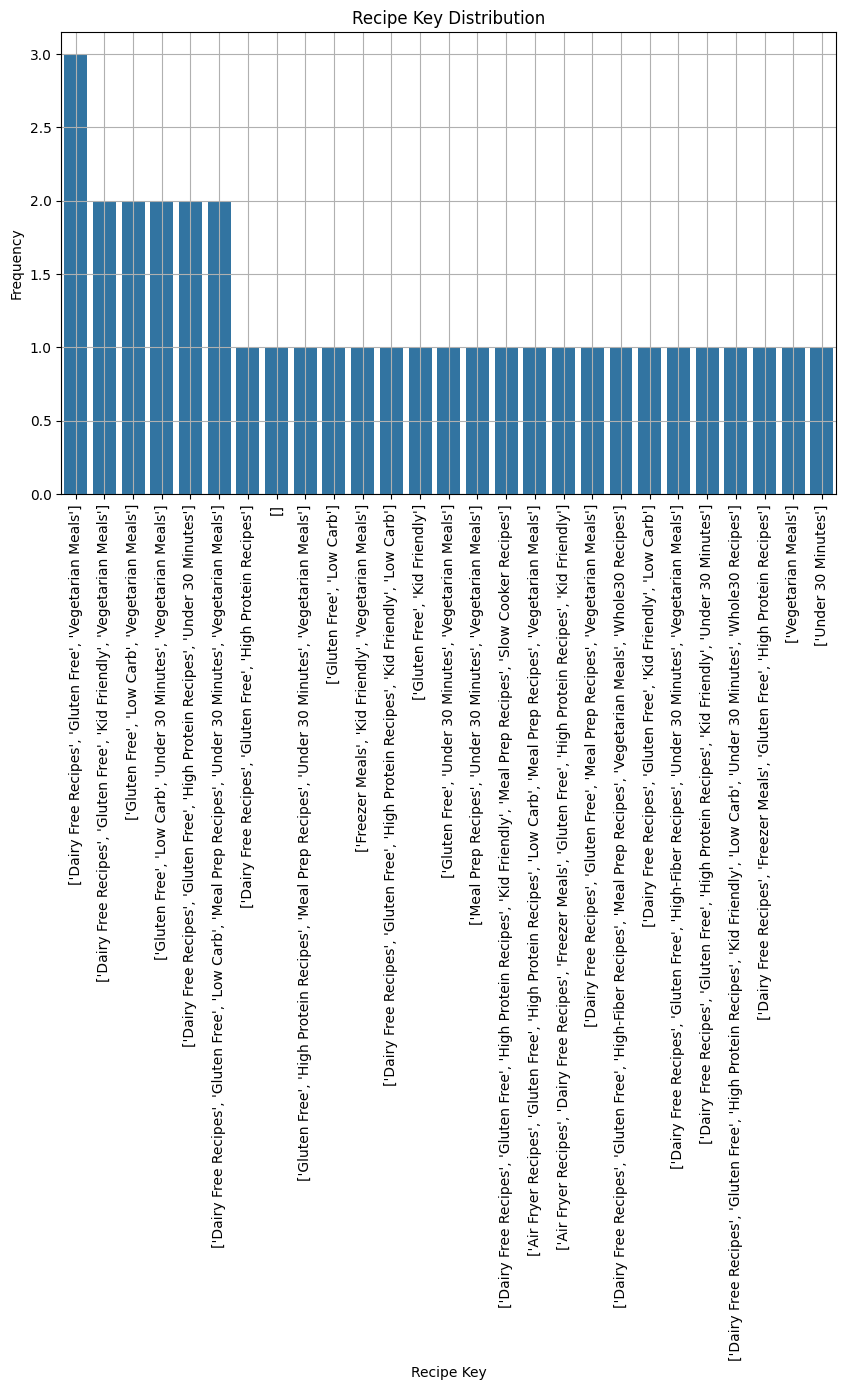

In [144]:
# Plotting Recipe Key Distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='The recipe Key', order=df['The recipe Key'].value_counts().index)
plt.title('Recipe Key Distribution')
plt.xlabel('Recipe Key')
plt.ylabel('Frequency')

# Rotate x labels by 90 degrees
plt.xticks(rotation=90)

plt.grid()
plt.tight_layout()  # Ensure everything fits well
plt.show()


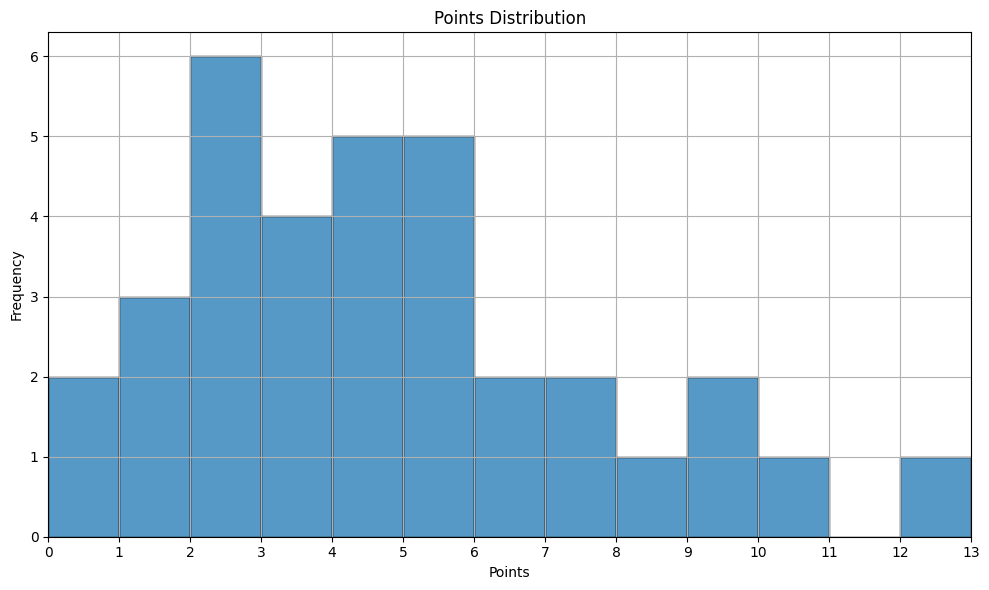

In [147]:
# Ensure 'Points' column is numeric
df['Points'] = pd.to_numeric(df['Points'], errors='coerce')

# Define the maximum limit for the data
max_limit_points = df['Points'].max() + 1 if not df['Points'].isnull().all() else 10  # Adjust if needed
bin_size_points = 1

# Calculate bins dynamically
bins_points = range(0, int(max_limit_points) + bin_size_points, bin_size_points)  # Create bins based on max limit

# Plotting Points Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['Points'], bins=bins_points, kde=False)  # Set kde=False to show just the histogram
plt.title('Points Distribution')
plt.xlabel('Points')
plt.ylabel('Frequency')

# Set x-ticks to show the bin values as labels
plt.xticks(bins_points)  # Show the bin values as labels
plt.xlim(0, int(max_limit_points))  # Adjust the x-axis limits to match your bin range

plt.grid()
plt.tight_layout()  # Ensure everything fits well
plt.show()
